# SQL Agent

In [7]:
import os
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float, TIMESTAMP 
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from langchain_core.runnables.config import RunnableConfig

from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
sql_llm = ChatGroq(model_name= "llama-3.3-70b-specdec")

In [8]:
DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///./db/hr.db")
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
SessionLocal

sessionmaker(class_='Session', autocommit=False, bind=Engine(sqlite:///./db/hr.db), autoflush=False, expire_on_commit=True)

In [9]:
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, START, END

In [10]:
def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    return schema

schema = get_database_schema(engine=engine)
print(schema)

Retrieved database schema.
Table: PERSONNEL
- ID: TEXT
- NAME: TEXT
- BIRTH: TIMESTAMP
- AGE: INTEGER
- GENDER: TEXT
- POSITION: TEXT
- DEPT: TEXT
- LEADERSHIP: TEXT
- EMPLOYMENT_DATE: TIMESTAMP
- PROMOTION_DATE: TIMESTAMP
- LEADERSHIP_DATE: TIMESTAMP
- 인사평가평균: REAL
- 인사평가석차비율: REAL
- 출신학교: TEXT
- 전공: TEXT
- 최근_주요_근무경력: TEXT
- 강점: TEXT
- 약점: TEXT




In [11]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question

    """
   
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool

GraphState

__main__.GraphState

In [12]:
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: GraphState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.

Schema:
{schema}

Respond with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = sql_llm
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

# question = "2024년도에 직원 숫자가 가장 많았던 날짜들과 인원 숫자를 알려주세요."
# question = "사번이 A10000인 홍길동의 동일 직위내 인사평가 석차비율은?"
question = "직위가 매니저인 직원중 인사평가평균 점수가 제일 높은 직원의 인사정보를 한글로 알려주세요?(성명, 생년월일, 연령, 입사일자 등을 포함해주세요)"

GraphState = {"question": question, "attempts": 0}
GraphState
result = check_relevance(state=GraphState, config=None)
result


Retrieved database schema.
Checking relevance of the question: 직위가 매니저인 직원중 인사평가평균 점수가 제일 높은 직원의 인사정보를 한글로 알려주세요?(성명, 생년월일, 연령, 입사일자 등을 포함해주세요)
Relevance determined: relevant


{'question': '직위가 매니저인 직원중 인사평가평균 점수가 제일 높은 직원의 인사정보를 한글로 알려주세요?(성명, 생년월일, 연령, 입사일자 등을 포함해주세요)',
 'attempts': 0,
 'relevance': 'relevant'}

In [13]:
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the natural language question."
    )

def convert_nl_to_sql(state: GraphState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Converting question to SQL : {question}")
    system = f"""You are an assistant that converts natural language questions into SQL queries based on the following schema:

{schema}

Provide only the SQL query without any explanations. 
Alias columns appropriately to match the expected keys in the result.

"""
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    llm = sql_llm
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    state["sql_query"] = result.sql_query
    # print(f">>> Generated SQL query: {state['sql_query']}")
    return state

result = convert_nl_to_sql(state=GraphState, config=None)
result

Retrieved database schema.
Converting question to SQL : 직위가 매니저인 직원중 인사평가평균 점수가 제일 높은 직원의 인사정보를 한글로 알려주세요?(성명, 생년월일, 연령, 입사일자 등을 포함해주세요)


{'question': '직위가 매니저인 직원중 인사평가평균 점수가 제일 높은 직원의 인사정보를 한글로 알려주세요?(성명, 생년월일, 연령, 입사일자 등을 포함해주세요)',
 'attempts': 0,
 'relevance': 'relevant',
 'sql_query': "SELECT NAME AS 성명, BIRTH AS 생년월일, AGE AS 연령, EMPLOYMENT_DATE AS 입사일자, 인사평가평균 AS 인사평가평균 FROM PERSONNEL WHERE POSITION = '매니저' ORDER BY 인사평가평균 DESC LIMIT 1"}

In [14]:
def execute_sql(state: GraphState):
    sql_query = state["sql_query"].strip()
    session = SessionLocal()
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            # print(f">>> rows: {rows}")
            # print(f">>> columns: {columns}")
            if rows:
                header = columns # ", ".join(columns)
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                # print(f"Raw SQL Query Result: {state['query_rows']}")





                # Format the result for readability
                data = rows[0]   ### 쿼리 결과의 탑 1번째 값만 취하는 경우가 아니라면, 문제가 있다.. (예컨데.. 상위 3개.. 이런식의 질문에 대응하지 못한다.)
                formatted_result = [f"{a}: {b}" for a, b in zip(header, data)]
                formatted_result = ", ".join(formatted_result)

                # print(f">>> header: {header}")
                # print(f">>> state_query_rows: {state["query_rows"]}")
                # print(f">>> data1: {data}")
                data = [str(i) for i in data]
                data = ", ".join(data)
                # print(f">>> data2: {data}")
                # print(f">>> formatted_result: {formatted_result}")





            else:
                state["query_rows"] = []
                formatted_result = "No results found."
            state["query_result"] = formatted_result
            state["sql_error"] = False
            print("SQL SELECT query executed successfully.")
        else:
            session.commit()
            state["query_result"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state

result = execute_sql(state=GraphState)
result

Executing SQL query: SELECT NAME AS 성명, BIRTH AS 생년월일, AGE AS 연령, EMPLOYMENT_DATE AS 입사일자, 인사평가평균 AS 인사평가평균 FROM PERSONNEL WHERE POSITION = '매니저' ORDER BY 인사평가평균 DESC LIMIT 1
SQL SELECT query executed successfully.


{'question': '직위가 매니저인 직원중 인사평가평균 점수가 제일 높은 직원의 인사정보를 한글로 알려주세요?(성명, 생년월일, 연령, 입사일자 등을 포함해주세요)',
 'attempts': 0,
 'relevance': 'relevant',
 'sql_query': "SELECT NAME AS 성명, BIRTH AS 생년월일, AGE AS 연령, EMPLOYMENT_DATE AS 입사일자, 인사평가평균 AS 인사평가평균 FROM PERSONNEL WHERE POSITION = '매니저' ORDER BY 인사평가평균 DESC LIMIT 1",
 'query_rows': [{'성명': '오타니',
   '생년월일': '1975-02-01 00:00:00',
   '연령': 50,
   '입사일자': '2005-06-04 00:00:00',
   '인사평가평균': 9.0}],
 'query_result': '성명: 오타니, 생년월일: 1975-02-01 00:00:00, 연령: 50, 입사일자: 2005-06-04 00:00:00, 인사평가평균: 9.0',
 'sql_error': False}

In [15]:
def generate_human_readable_answer(state: GraphState):

    sql = state["sql_query"]
    result = state["query_result"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)

    # print(f">>> sql: {sql}")
    # print(f">>> result: {result}")
    # print(f">>> query_rows: {query_rows}")
    # print(f">>> sql_error: {sql_error}")

    print("Generating a human-readable answer.")
    system = f"""You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs. 
    """
    if sql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable error message in a single sentence, informing them about the issue.

"""
                ),
            ]
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle cases with no orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence.
Generate the final answer in Korean(Han-gul)"""
                    ),
                ]
            )
        else:
            # Handle displaying orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence. 
Generate the final answer in Korean(Han-gul)"""
                    ),
                ]
            )
    else:
        # Handle non-select queries
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable confirmation message in a single sentence, confirming that your request has been successfully processed.
Generate the final answer in Korean(Han-gul)"""
                ),
            ]
        )
    
    print(f">>> generate_prompt: {generate_prompt}")

    human_response = generate_prompt | sql_llm | StrOutputParser()

    answer = human_response.invoke({})
    state["query_result"] = answer
    # print("Generated human-readable answer.")
    return state

result = generate_human_readable_answer(state=GraphState)
result

Generating a human-readable answer.
>>> generate_prompt: input_variables=[] input_types={} partial_variables={} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs. \n    '), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="SQL Query:\nSELECT NAME AS 성명, BIRTH AS 생년월일, AGE AS 연령, EMPLOYMENT_DATE AS 입사일자, 인사평가평균 AS 인사평가평균 FROM PERSONNEL WHERE POSITION = '매니저' ORDER BY 인사평가평균 DESC LIMIT 1\n\nResult:\n성명: 오타니, 생년월일: 1975-02-01 00:00:00, 연령: 50, 입사일자: 2005-06-04 00:00:00, 인사평가평균: 9.0\n\nFormulate a clear and understandable answer to the original question in a single sentence. \nGenerate the final answer in Korean(Han-gul)"), additional_kwargs={})]


{'question': '직위가 매니저인 직원중 인사평가평균 점수가 제일 높은 직원의 인사정보를 한글로 알려주세요?(성명, 생년월일, 연령, 입사일자 등을 포함해주세요)',
 'attempts': 0,
 'relevance': 'relevant',
 'sql_query': "SELECT NAME AS 성명, BIRTH AS 생년월일, AGE AS 연령, EMPLOYMENT_DATE AS 입사일자, 인사평가평균 AS 인사평가평균 FROM PERSONNEL WHERE POSITION = '매니저' ORDER BY 인사평가평균 DESC LIMIT 1",
 'query_rows': [{'성명': '오타니',
   '생년월일': '1975-02-01 00:00:00',
   '연령': 50,
   '입사일자': '2005-06-04 00:00:00',
   '인사평가평균': 9.0}],
 'query_result': '최근 인사평가에서最高 점수를 받은 매니저는 1975년 2월 1일에 태어나서 2005년 6월 4일에 입사하여 현재 50세인 오타니이며, 그의 인사평가 평균은 9.0점입니다.',
 'sql_error': False}

In [16]:
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: GraphState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. 
    Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = sql_llm
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    # state = {"question": rewritten.question}
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state

# result = regenerate_query(state=GraphState)
# result

In [17]:
def relevance_router(state: GraphState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "no_relevance"

def execute_sql_router(state: GraphState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

def check_attempts_router(state: GraphState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

def end_max_iterations(state: GraphState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

In [18]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question

    """
   
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool



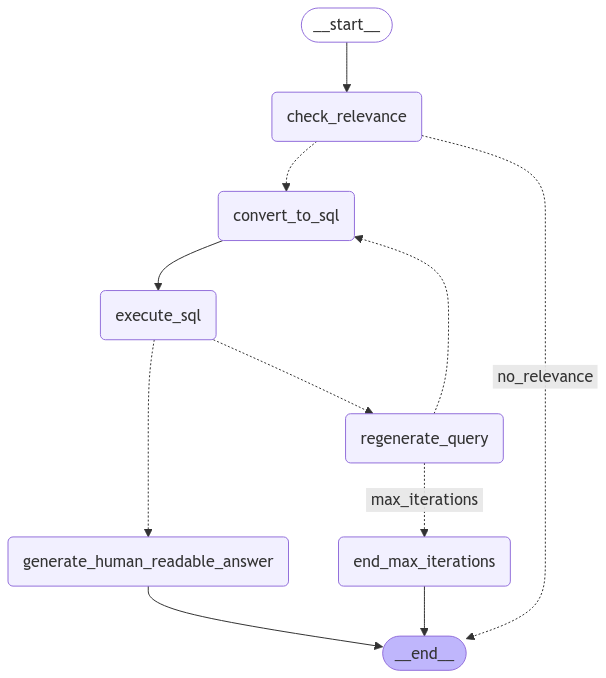

In [19]:

def sql_builder(state):
    sql_builder = StateGraph(state)
    sql_builder.add_node("check_relevance", check_relevance)
    sql_builder.add_node("convert_to_sql", convert_nl_to_sql)
    sql_builder.add_node("execute_sql", execute_sql)
    sql_builder.add_node("generate_human_readable_answer", generate_human_readable_answer)
    sql_builder.add_node("regenerate_query", regenerate_query)
    sql_builder.add_node("end_max_iterations", end_max_iterations)

    sql_builder.add_edge(START, "check_relevance")
    sql_builder.add_conditional_edges(
        "check_relevance",
        relevance_router,
        {
            "convert_to_sql": "convert_to_sql",
            "no_relevance": END,
        },
    )
    sql_builder.add_edge("convert_to_sql", "execute_sql")

    sql_builder.add_conditional_edges(
        "execute_sql",
        execute_sql_router,
        {
            "generate_human_readable_answer": "generate_human_readable_answer",
            "regenerate_query": "regenerate_query",
        },
    )

    sql_builder.add_conditional_edges(
        "regenerate_query",
        check_attempts_router,
        {
            "convert_to_sql": "convert_to_sql",
            "max_iterations": "end_max_iterations",
        },
    )

    sql_builder.add_edge("generate_human_readable_answer", END)
    sql_builder.add_edge("end_max_iterations", END)

    return sql_builder.compile()

graph = sql_builder(GraphState)

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
from langgraph.errors import GraphRecursionError
%timeit
# Run
def app_stream(question:str, recursion_limit:int=10):
    inputs = {
        "question": question, 
        }
    config = {
        "recursion_limit": recursion_limit, 
        # "configurable": {"thread_id": "1"}
        }
    try:
        for output in graph.stream(inputs, 
                                config, 
                                # stream_mode="debug"
                                ):
            for key, value in output.items():
                # Node
                print(f">>> Node : {key}")
            print("="*70)

        # Final generation
        print("")
        print(value)
    except GraphRecursionError:
        print(f"=== Recursion Error - {recursion_limit} ===")
        value = f"=== Recursion Error - {recursion_limit} ==="
    
    return value

In [21]:
사번 = "A10001"
성명 = "류현진"

# 사번 = "A10003"
# 성명 = "이정우"

In [22]:
q1 = f"name이 {성명}이고 ID가 {사번}인 직원의 부서, 성별, 연령은?(응답에 성명을 포함해주세요)"
q2 = f"name이 {성명}이고 ID가 {사번}인 직원의 직위와 승진날짜는?(응답에 성명을 포함해주세요)"
q3 = f"name이 {성명}이고 ID가 {사번}인 직원의 리더쉽 명칭이 있다면, 리더쉽 명칭과 직책보임 날짜는?(응답에 성명을 포함해주세요)"
q4 = f"name이 {성명}이고 ID가 {사번}인 직원의 인사평가와 석차비율은?(응답에 성명을 포함해주세요)"
q5 = f"name이 {성명}이고 ID가 {사번}인 직원의 출신학교와 전공은?(응답에 성명을 포함해주세요)"
q6 = f"name이 {성명}이고 ID가 {사번}인 직원의 최근 주요 근무경력은은?(응답에 성명을 포함해주세요)"
q7 = f"name이 {성명}이고 ID가 {사번}인 직원의 인사평가평균 점수 및 동일 POSITION내 등수(RANK)는?(응답에 성명을 포함해주세요)"
q8 = f"name이 {성명}이고 ID가 {사번}인 직원의 강점와 약점에 대해 설명해주세요요?(응답에 성명을 포함해주세요)"
questions = [q1, q2, q3, q4, q5, q6, q7, q8]

In [23]:
total_results = []
for question in questions:
    result = app_stream(question=question, recursion_limit=5)
    print(result["query_result"])
    total_results.append(result["query_result"])
    print("-"*70)

Retrieved database schema.
Checking relevance of the question: name이 류현진이고 ID가 A10001인 직원의 부서, 성별, 연령은?(응답에 성명을 포함해주세요)
Relevance determined: relevant
>>> Node : check_relevance
Retrieved database schema.
Converting question to SQL : name이 류현진이고 ID가 A10001인 직원의 부서, 성별, 연령은?(응답에 성명을 포함해주세요)
>>> Node : convert_to_sql
Executing SQL query: SELECT DEPT AS 부서, GENDER AS 성별, AGE AS 연령, NAME AS 이름 FROM PERSONNEL WHERE NAME = '류현진' AND ID = 'A10001'
SQL SELECT query executed successfully.
>>> Node : execute_sql
Generating a human-readable answer.
>>> generate_prompt: input_variables=[] input_types={} partial_variables={} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs. \n    '), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_ty

In [24]:
total_results

['류현진은 사업기획부에서 근무하는 43세 남성입니다.',
 '류현진은 2022년 1월 1일에 책임연구원으로 승진했습니다.',
 '류현진은 2022년 1월 1일에 직책과장으로 승진했습니다.',
 '류현진의 인사평가 평균은 7.5이며, 전체 순위 중에서 류현진의 순위 비율은 약 57.14%입니다.',
 '류현진의 출신학교는 고려대학교이며, 전공은 산업공학입니다.',
 '류현진은 사업기획부에서 3년, 건조1부에서 8년을 근무한 경험이 있습니다.',
 '류현진의 인사 평가 평균은 7.5로, 해당 직급에서最高評価를 받았습니다.',
 '류현진은 생산부서와 사업기획부서 근무 경험을 보유하여 계획과 실행에 대한 구체적 이해도를 가지고 있습니다.']

# Generation Agent

In [25]:
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model_name= "deepseek-r1-distill-llama-70b")

In [26]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

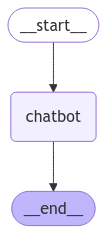

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [34]:
user_input = f"""
아래 HR Personnel information을 참고하여, 최고경영 임원에게 제공할 직원 개인에 대한 HR Report를 작성해주세요.
HR 리포트 작성시 아래 기준을 참고하여 작성해주세요.(직원의 강점, 특징, 보완할 사항 등을 언급해주세요.)
The Final Answer Must be generated in Korean (Han-gul)

<인사기준>
- 직책보임 연령 기준 : 44세 미만
- 인사평가 기준 : 7.5 이상
- 리더쉽 임기 : 3년 (올해는 2025년)


<개인 인사정보>
{total_results}

"""

In [35]:
stream_graph_updates(user_input=user_input)

Assistant: <think>
Alright, I need to help the user by creating an HR report for Ryu Hyun-jin based on the provided information. Let me start by understanding the user's query and the data given.

First, the user wants the report to be in Korean, so I'll make sure to write it in Hangul. The report should include strengths, characteristics, areas for improvement, and a conclusion. The user also provided specific criteria: age under 44, performance evaluation above 7.5, and leadership term of 3 years, with the current year being 2025.

Looking at Ryu Hyun-jin's information, he's 43, which fits the age criterion. His performance evaluation is exactly 7.5, which is the minimum, but he's noted as having the highest evaluation in his rank. He was promoted to a position in 2022 and has 3 years in the business planning department and 8 years in the construction department. His education is from Korea University, majoring in industrial engineering.

I should highlight his strengths, like his ex

In [37]:
import time
temp = []
async for event in graph.astream_events({"messages": [{"role": "user", "content": user_input}]}, version="v1"):
    if event['event'] == 'on_chat_model_stream' or event['event'] == 'on_llm_stream':
        # print(event)
        try:
            response = event['data']['chunk'].content   # groq
            temp.append(response)
            print(response, end="")  
            time.sleep(0.1)
        except:
            response = event['data']['chunk']  # ollama
            temp.append(response)
            print(response, end="")    
            time.sleep(0.1)
        finally: pass
    else: pass

<think>
Alright, I need to help the user by creating an HR report for Ryu Hyun-jin based on the provided information. Let me start by understanding the user's query and the data given.

First, the user wants the report to be in Korean, so I'll make sure to write it in Hangul. The report should include strengths, characteristics, areas for improvement, and a conclusion. The user also provided specific criteria: age under 44, performance evaluation above 7.5, and leadership term of 3 years, with the current year being 2025.

Looking at Ryu Hyun-jin's information, he's 43, which fits the age criterion. His performance evaluation is exactly 7.5, which is the minimum, but he's noted as having the highest evaluation in his rank. He has a strong educational background from Korea University, majoring in Industrial Engineering. His work experience includes 3 years in the business planning department and 8 years in the construction department, giving him a good mix of planning and execution expe